# 概述

k-近邻算法可以完成很多分类任务，但是最大的缺点就是无法给出数据内在含义，决策树的主要优势就在于数据形式非常容易理解

优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据  
缺点：可能会产生过度匹配问题  
适用数据类型：数值型和标称型

# 决策树的构造

## 信息增益

在划分数据集之前之后信息发生的变化成为信息增益  
计算每个特征值划分数据集获得的信息增益，选择获得信息增益最高的特征

符号$x_i$的信息定义为  
$$l(x_i)=-log_2p(x_i)$$  
其中$p(x_i)$是选择该分类的概率  
  
信息期望值（熵）为  
$$H=-\sum_{i=1}^{n}{p(x_i)log_2p(x_i)}$$

In [1]:
from math import log
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    # 计算每个特征出现的次数（注意特征默认为在每一行记录的最后一个元素）
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0
    # 计算每个特征的概率及信息期望值
    for key in labelCounts:
        prob = labelCounts[key] / numEntries
        #print("标签%s的分类概率为：%s" % (key, prob))
        #print("信息期望值（熵）为：%s" % (-log(prob, 2)))
        shannonEnt -= prob*log(prob, 2)
    return shannonEnt

In [2]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

myDat, labels = createDataSet()
calcShannonEnt(myDat)

0.9709505944546686

熵越高，则混合的数据也越多  

In [3]:
myDat[0][-1] = 'maybe'
print(myDat)
calcShannonEnt(myDat) # 增加了分类，熵的值变大，越无序

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


1.3709505944546687

另一个度量集合无序程度的方法是基尼不纯度（Gini impurity），简单的说就是从一个数据集种随机选取子项，度量其被错误分类到其他分组里的概率。

## 划分数据集

In [4]:
# dataSet:待划分的数据集； axis:划分数据集的特征（相当于columns）； value:需要返回特征的值
# 讲符合特征axis=value的数据集dataSet取出来，剔除axis这个字段重组成列表存储
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

In [5]:
myDat, labels = createDataSet()
print(myDat)
splitDataSet(myDat, 0, 1)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [6]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1 # 字段的数量
    baseEntropy = calcShannonEnt(dataSet) # 原数据集的熵
    bestInfoGain = 0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet] # 把一列的特征值取了出来
        uniqueVals = set(featList) # 去重得到所有可能取值
        newEntropy = 0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value) # 对每个字段的特征值循环，划分子数据集，计算子数据集的熵
            prob = len(subDataSet) / len(dataSet)
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

myDat, labels = createDataSet()
chooseBestFeatureToSplit(myDat)

0

## 递归构建决策树

递归结束的条件：程序遍历完所有划分数据集的属性，或者每个分支下的所有实例都具有相同的分类。  
如果数据集已经处理了所有属性，但是类标签依然不是唯一的，通常会采用多数表决的方法决定该叶子节点的分类

In [7]:
import operator
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [8]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): # 当数据集内标签类别完全相同则停止分类
        return classList[0]
    if len(dataSet[0]) == 1: # 当所有特征遍历完了，返回该叶子结点的标签（多数表决原则）
        majorityCnt(classList) # 写成majorityCnt(dataSet)应该也是可以的
    bestFeat = chooseBestFeatureToSplit(dataSet) # 挑选一个信息增益最大的特征字段
    bestFeatLabel = labels[bestFeat] # 特征字段对应的字段名称
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet] # 用来分类的字段的所有可能取值
    uniqueValues = set(featValues)
    for value in uniqueValues:
        subLabels = labels[:] # 复制类标签，为了不改变原始列表的内容
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree
myDat, labels = createDataSet()
createTree(myDat, labels)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 用Matplotlib绘图

## Matplotlib注解

In [12]:
import warnings
warnings.filterwarnings("ignore")

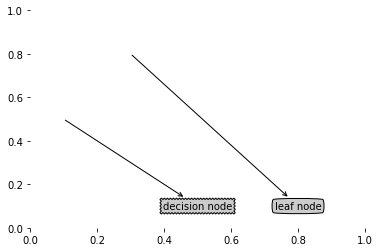

In [19]:
# 使用文本注解绘制树节点
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'

decisionNode = dict(boxstyle='sawtooth', fc="0.8")
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.axl.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.axl = plt.subplot(111, frameon=False)
    plotNode(U'decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode(U'leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()
    
createPlot()

## 构造注解树

In [44]:
# 获取叶节点的数目和树的层数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    if type(secondDict).__name__ != 'dict':
        return 1
    else:
        for key in secondDict.keys():
            if type(secondDict[key]).__name__ == 'dict': # 如果字典内的值也是一个字典，说明该节点还是叶节点，需要继续往下迭代
                numLeafs += getNumLeafs(secondDict[key])
            else:
                numLeafs += 1
        return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    if type(secondDict).__name__ != 'dict':
        return 1
    else:
        for key in secondDict.keys():
            if type(secondDict[key]).__name__ == 'dict':
                thisDepth = 1 + getTreeDepth(secondDict[key])
            else:
                thisDepth = 1
            if thisDepth > maxDepth:
                maxDepth = thisDepth
        return maxDepth

In [20]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels)

In [30]:
getNumLeafs(myTree)

3

In [31]:
getTreeDepth(myTree)

2

In [ ]:
decisionNode = dict(boxstyle='sawtooth', fc="0.8")
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.axl.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.axl = plt.subplot(111, frameon=False)
    plotNode(U'decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode(U'leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

AttributeError: 'str' object has no attribute 'keys'

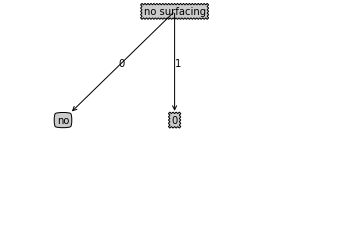

In [57]:
# plotTree

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2 + cntrPt[1]
    createPlot.axl.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1 + numLeafs)/2/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict, cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.axl = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = getNumLeafs(inTree)
    plotTree.totalD = getTreeDepth(inTree)
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1
    plotTree(inTree, (0.5, 1), '')
    plt.show()

myDat, labels = createDataSet()
testTree = createTree(myDat, labels.copy())
createPlot(testTree)

# 测试和存储分类器

## 测试算法：使用决策树执行分类

In [56]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0] # 树节点对应的特征名称
    secondDict = inputTree[firstStr] 
    featIndex = featLabels.index(firstStr) # 取出树节点对应的特征名称 在变量中的位置
    for key in secondDict.keys():
        if testVec[featIndex] == key: # 遍历所有取值
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

myDat, labels = createDataSet()
myTree = createTree(myDat, labels.copy())
classify(myTree, labels, [1, 0])

'no'

## 使用算法：决策树的存储

In [58]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

# 示例：预测隐形眼镜类型

In [64]:
with open('./lenses.txt') as fr:
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lensesTree = createTree(lenses, lensesLabels)
    
lensesTree




{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'presbyopic': {'prescript': {'myope': 'no lenses',
        'hyper': 'soft'}},
      'pre': 'soft',
      'young': 'soft'}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'presbyopic': 'no lenses',
        'pre': 'no lenses',
        'young': 'hard'}}}}}},
  'reduced': 'no lenses'}}

# 用dataFrame实现算法

In [29]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
# load_*() 加载并返回鸢尾花数据集 （scikit-learn自带的数据集）
iris_data = load_iris()  # 返回datasets.base.Bunch类型(字典格式)
data = pd.DataFrame(data=iris_data['data'], columns=iris_data['feature_names'])
data['target'] = iris_data['target']
data.columns = [i.replace(" (cm)", "") for i in data.columns]
data.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [36]:
# 计算数据集的熵
from math import log
def calcShannonEnt(dataSet, targetColumnName='target'):
    dataSet['cnt'] = 1
    df = dataSet.groupby(targetColumnName)[['cnt']].sum().reset_index()
    df['rate'] = df['cnt'] / df['cnt'].sum()
    shannonEnt = 0
    for prob in df['rate'].values:
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt
calcShannonEnt(data)

1.584962500721156

In [38]:
# 通过信息增益选择最适合划分数据集的特征
def chooseBestFeature(dataSet, targetColumnName='target'):
    baseEntropy = calcShannonEnt(dataSet, targetColumnName)
    bestInfoGain = 0
    bestFeature = ""
    for col in [i for i in dataSet.columns if i!=targetColumnName]:
        uniqueVals = list(dataSet[col].unique())
        newEntropy = 0
        for value in uniqueVals:
            subDataSet = dataSet[dataSet[col]==value]
            prob = len(subDataSet) / len(dataSet)            
            newEntropy += prob * calcShannonEnt(subDataSet, targetColumnName)
        infoGain = baseEntropy - newEntropy
        if infoGain>bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = col
    return bestFeature
chooseBestFeature(data)

<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet['cnt'] = 1
<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet['cnt'] = 1
<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet['cnt'] = 1
<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet['cnt'] = 1
<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet['cnt'] = 1
<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet['cnt'] = 1
<ipython-input-36-74c7fb14c3bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

'petal length'